In [71]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
rng = np.random.default_rng()

In [75]:
def run_lattice_heatbath(U_state,beta,n):
    """Perform n heatbath updates on the lattice state U_state."""
    for _ in range(n):
        lattice_heatbath_update(U_state,beta)

def lattice_heatbath_update(U_state,beta):
    """Perform a random heatbath update on the lattice state U_state."""
    site = tuple(rng.integers(0,len(U_state),4))
    theta = sample_link_variable_angle(beta)
    U_state[site] = np.exp(1j*theta)

def sample_link_variable_angle(beta):
    """Sample angle theta defined via link variable angle U = exp(i*theta)."""
    alpha = np.sqrt(2*beta)*beta
    while True:
        Z = rng.uniform(0,1)
        x = -1 + np.log(1 + np.exp(2*alpha - 1)*Z)/alpha

        Q = np.exp(alpha*(np.cos(np.pi/2*(1-x))-x))
        Q_max = np.exp(0.2105137*alpha)

        Z_prime = rng.uniform(0,1)
        if Q/Q_max > Z_prime:
            angle = np.pi*(1-x)/2
            return angle

def lattice_action(U_state):
    """Compute action of the lattice state U_state."""
    action = 0
    plaquettes = unique_unoriented_plaquettes(len(U_state))
    for plaquette in plaquettes:
        action += 1 - np.real(plaquette_product(U_state,plaquette))
    return action

def unique_unoriented_plaquettes(width):
    """Compute all the unique unoriented plaquettes for a 4D lattice,
    which is done by computing all possible plaquettes, sorting them,
    and only keeping unique ones."""
    plaquettes = []
    for n_x in range(width-1):
        for n_y in range(width-1):
            for n_z in range(width-1):
                for n_t in range(width-1):
                    plaquette = [
                        (n_x,n_y,n_z,n_t),
                        (n_x+1,n_y,n_z,n_t),
                        (n_x+1,n_y+1,n_z,n_t),
                        (n_x,n_y+1,n_z,n_t),
                    ]
                    sorted_plaquette = tuple(sorted(plaquette))
                    if sorted_plaquette not in plaquettes:
                        plaquettes.append(sorted_plaquette)
    return plaquettes

def plaquette_product(U_state,plaquette):
    """Compute the product of link variables around an elementary plaquette."""
    site_1, site_2, site_3, site_4 = plaquette
    U_12 = np.dot(U_state[site_1], U_state[site_2])
    U_23 = np.dot(U_state[site_2], U_state[site_3])
    U_34 = np.dot(U_state[site_3], U_state[site_4])
    U_41 = np.dot(U_state[site_4], U_state[site_1])
    return U_12*U_23*U_34*U_41

def ordered_state(width):
    return np.exp(2j * np.pi * np.zeros((width,width,width,width,4)))

def disordered_state(width):
    return np.exp(2j * np.pi * np.random.rand(width,width,width,width,4))

In [76]:
def run_simulation(U_state,beta,k,n,measurements):
    """Run the simulation with k equilibration sweeps and n measurement sweeps.
    Returns the action measurement results."""
    num_sites = len(U_state)**4

    # equilibrate
    run_lattice_heatbath(U_state,beta,k*num_sites)

    # measure
    results = np.empty(measurements)
    for i in range(measurements):
        run_lattice_heatbath(U_state,beta,n*num_sites)
        results[i] = lattice_action(U_state)

    return results

In [77]:
width = 4
beta = 0.55
equil_sweeps = 0
measure_sweeps = 1
measurements = 360

with h5py.File('lattice.hdf5','a') as f:
    if not "beta0.55-average-action-per-iterations" in f:
        U_state = ordered_state(width)
        action_measurements = run_simulation(U_state,beta,equil_sweeps,measure_sweeps,measurements)
        f.create_dataset("beta0.55-average-action-per-iterations",data=action_measurements)

Mean: 7.535413166913789


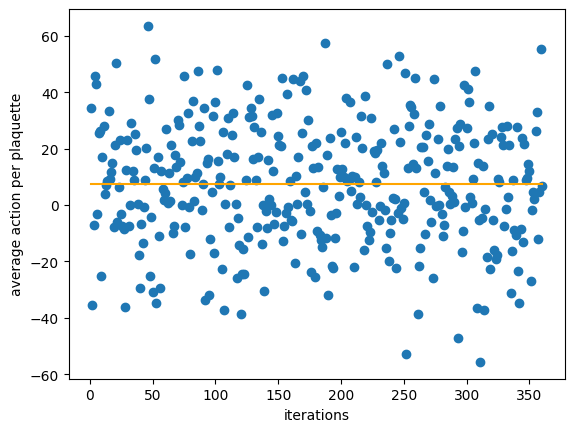

In [78]:
with h5py.File('lattice.hdf5','r') as f:
    action_measurements = f["beta0.55-average-action-per-iterations"][()]

    num_plaquettes = len(unique_unoriented_plaquettes(width))
    actions = [action / num_plaquettes for action in action_measurements]

    plt.scatter(np.linspace(1,measurements,measurements),actions)
    plt.xlabel("iterations")
    plt.ylabel("average action per plaquette")

    plt.plot(np.linspace(1,measurements,measurements),[np.mean(actions) for _ in range(measurements)],color="orange")

    print(f"Mean: {np.mean(actions)}")

In [79]:
width = 4
beta = 1.000
equil_sweeps = 0
measure_sweeps = 1
measurements = 360

with h5py.File('lattice.hdf5','a') as f:
    if not "beta1-average-action-per-iterations" in f:
        U_state = ordered_state(width)
        action_measurements = run_simulation(U_state,beta,equil_sweeps,measure_sweeps,measurements)
        f.create_dataset("beta1-average-action-per-iterations",data=action_measurements)

Mean: -12.611019771976263


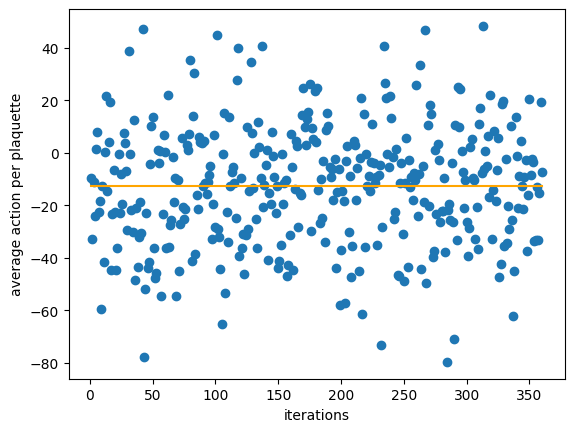

In [80]:
with h5py.File('lattice.hdf5','r') as f:
    action_measurements = f["beta1-average-action-per-iterations"][()]

    num_plaquettes = len(unique_unoriented_plaquettes(width))
    actions = [action / num_plaquettes for action in action_measurements]

    plt.scatter(np.linspace(1,measurements,measurements),actions)
    plt.xlabel("iterations")
    plt.ylabel("average action per plaquette")

    plt.plot(np.linspace(1,measurements,measurements),[np.mean(actions) for _ in range(measurements)],color="orange")

    print(f"Mean: {np.mean(actions)}")

(4, 4, 4, 4, 4)